In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import os
from scipy.stats import gamma
from IPython.display import HTML
from mlxtend.frequent_patterns import apriori, association_rules
import base64
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-analyst-jobs/DataAnalyst.csv


In [2]:
df= pd.read_csv('/kaggle/input/data-analyst-jobs/DataAnalyst.csv')
cols = ['Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Easy Apply']

df = df[cols]
df.head(3)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2253 non-null   object 
 1   Salary Estimate    2253 non-null   object 
 2   Job Description    2253 non-null   object 
 3   Rating             2253 non-null   float64
 4   Company Name       2252 non-null   object 
 5   Location           2253 non-null   object 
 6   Headquarters       2253 non-null   object 
 7   Size               2253 non-null   object 
 8   Founded            2253 non-null   int64  
 9   Type of ownership  2253 non-null   object 
 10  Industry           2253 non-null   object 
 11  Sector             2253 non-null   object 
 12  Revenue            2253 non-null   object 
 13  Competitors        2253 non-null   object 
 14  Easy Apply         2253 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 264.1+ KB


In [4]:
def preprocessing(df):
    df.Location=df['Location'].apply(lambda x:x.split(',')[0])                  ## Split the state code and state name.
    df['Salary Estimate'] =df['Salary Estimate'].apply(lambda x:x.split(' ')[0].replace('K','').replace('$','').split('-')) ## Convert the salary estimate column into calculatable digit format 
    df['Floor Salary'] = df['Salary Estimate'].apply(lambda x: x[0])                    ## Split floor and top values
    df['Top Salary'] = df['Salary Estimate'].apply(lambda x: x[1])
    df.loc[df['Floor Salary'] == '','Floor Salary'] = 0                                 ## Input 0 as value for null values
    df.loc[df['Top Salary'] == '','Top Salary'] = 0
    df['Floor Salary']=df['Floor Salary'].astype(float)                       ## convert the string into float
    df['Top Salary']=df['Top Salary'].astype(float)
    df['Avg_Salary_Exp'] = (df['Top Salary'] + df['Floor Salary'])/2 * 1000          ## Get the average value for the row.
    df.drop(columns = ['Top Salary', 'Floor Salary','Salary Estimate','Type of ownership','Industry', 'Easy Apply','Competitors','Headquarters'],inplace=True)  ## drop unnecessary columns
    df.Rating =df.Rating.apply(lambda x : 0 if x<0 else x)                                ## assign 0 for ratings below zero
    df['Job Title']=df['Job Title'].apply(lambda x:x.lower())                             ## lower the job title to avoid duplications stemming from capitalization differences.
    df.loc[df['Job Title'].str.contains('data analyst')==True,'Job Title'] = 'Data Analyst'             ## assign a common value for all rows with job title that contains data analyst
    df.loc[df['Job Title'].str.contains('business')==True,'Job Title'] = 'Business Analyst'             ## same as above
    df['Job Title']=df['Job Title'].replace(r'[^ \D]','',regex=True)                  ## remove digits from job titles.
    df['Job Title']=df['Job Title'].apply(lambda x :x.title())                         ## make the first letters capital again
    df['Company Name']=df['Company Name'].astype('str')
    df['Company Name']= df['Company Name'].apply(lambda x:x.split('\n')[0])                 ## Clean the column from ratings attached to the company name.
    df.Size=df.Size.replace(r'employees','',regex=True)                                    ## remove unnecessary words
    df.Size=df.Size.replace('-1','Unknown')
    df.Size.value_counts()
    data_gamma = gamma.rvs(a=3.5, size=272)                                              ## Create a sample with average of 3.5
    
    df.loc[df.Rating ==0,'Rating'] = data_gamma                                          ## Assign the rating values in a way that will not change the mean of company ratings of entire dataset
    df.Rating = round(df.Rating,2)
    df.loc[df.Sector=='-1','Sector'] = df.Sector.mode()[0]                              ##  Imput the most common value for the missing values in the 'Sector' column
    df.Revenue = df.Revenue.replace(r'to', ' to ',regex=True).replace('-1','Unknown / Non-Applicable ')         ## replace minus revenue with 'Unknown'
preprocessing(df)

In [5]:
def requirements(df):    ## here I create columns for each skill requirement that takes place in the job descriptions. I chose the most common ones.
    sql_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('sql')==True].index         ## Get the index of job rows requiring SQL
    python_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('python')==True].index     ## Repeat the same for other skills
    tableau_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('tableau')==True].index
    BI_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('power bi')==True].index
    aws_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('aws')==True].index
    cloud_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('google cloud')==True].index
    azure_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('azure')==True].index
    ML_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('machine')==True].index
    excel_indd = df[df['Job Description'].apply(lambda x:x.lower().replace('\n',' ')).str.contains('excel')==True].index
    df['SQL'] = 0                                                                             ## Create a column that shows if the job requires SQL 
    df['Python'] = 0                                                                          ## Repeat the same for others
    df['Tableau'] = 0
    df['BI'] = 0
    df['AWS'] = 0
    df['GoogleCloud'] = 0
    df['Azure'] = 0
    df['Machine_Learning'] = 0
    df['Excel'] = 0
    df.loc[sql_indd,'SQL'] = 1                                                              ## the indices gathered above are used to input the values. 1 means 'the job requires this skill'
    df.loc[python_indd,'Python'] = 1                                                        ## Repeat the same for others
    df.loc[tableau_indd,'Tableau'] = 1
    df.loc[BI_indd,'BI'] = 1
    df.loc[aws_indd,'AWS'] = 1
    df.loc[cloud_indd,'GoogleCloud'] = 1
    df.loc[azure_indd,'Azure'] = 1
    df.loc[ML_indd,'Machine_Learning'] = 1
    df.loc[excel_indd,'Excel'] = 1
requirements(df)                                               ## call the function defined above.

In [6]:
df.head()

,Job Title,Job Description,Rating,Company Name,Location,Size,Founded,Sector,Revenue,Avg_Salary_Exp,SQL,Python,Tableau,BI,AWS,GoogleCloud,Azure,Machine_Learning,Excel
0,Data Analyst,Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,New York,201 to 500,1961,Non-Profit,$100 to $500 million (USD),51500.0,1,1,0,0,1,0,0,0,0
1,Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,New York,10000+,1893,Health Care,$2 to $5 billion (USD),51500.0,1,0,0,0,0,0,0,0,1
2,Data Analyst,We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,New York,1001 to 5000,2003,Information Technology,Unknown / Non-Applicable,51500.0,1,1,1,0,0,0,0,0,1
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,New York,201 to 500,2002,Information Technology,$50 to $100 million (USD),51500.0,1,0,1,0,1,0,0,0,0
4,Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,New York,501 to 1000,2009,"Arts, Entertainment & Recreation",$100 to $500 million (USD),51500.0,1,1,0,0,0,0,0,0,1


In [7]:
df.to_csv('mycsvfile.csv',index=False)    ## Save the file 

In [8]:
req =df.iloc[:,10:]     ## I define a variable for the columns that I created for skill requirements 

In [9]:
df_apriori=apriori(req,min_support=0.002, use_colnames=True)               ## Call an apriori function which shows the most common skills.
df_apriori

/opt/conda/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


,support,itemsets
0,0.616511,(SQL)
1,0.282734,(Python)
2,0.275189,(Tableau)
3,0.079893,(BI)
4,0.122059,(AWS)
...,...,...
167,0.002219,"(Tableau, Azure, Excel, AWS, Python)"
168,0.003551,"(Machine_Learning, Tableau, Excel, AWS, Python)"
169,0.003107,"(Tableau, BI, AWS, Excel, Python, SQL)"
170,0.003107,"(Machine_Learning, Tableau, BI, Excel, Python,..."


In [10]:
df_apriori['length'] =  df_apriori.itemsets.apply(lambda x: len(x))              ## Define a new length column in the apriori table. This column indicates the number of skills in a row.

In [11]:
df_apriori[df_apriori.length > 3].sort_values('length',ascending=False)          ## 

,support,itemsets,length
171,0.003107,"(Machine_Learning, Tableau, Excel, AWS, Python...",6
170,0.003107,"(Machine_Learning, Tableau, BI, Excel, Python,...",6
169,0.003107,"(Tableau, BI, AWS, Excel, Python, SQL)",6
158,0.003107,"(Machine_Learning, BI, Excel, Python, SQL)",5
148,0.004882,"(Tableau, BI, AWS, Python, SQL)",5
...,...,...,...
121,0.002663,"(Azure, BI, SQL, AWS)",4
120,0.022636,"(Tableau, Machine_Learning, Excel, SQL)",4
119,0.004882,"(Tableau, Azure, Excel, SQL)",4
118,0.022193,"(Tableau, Excel, SQL, AWS)",4


In [12]:
## the most in demand skill duos
in_demand2 = df_apriori[df_apriori.length ==2].sort_values('support',ascending=False)
in_demand2.head(5)

,support,itemsets,length
16,0.394141,"(Excel, SQL)",2
9,0.249001,"(Python, SQL)",2
10,0.235686,"(Tableau, SQL)",2
29,0.180648,"(Tableau, Excel)",2
23,0.166889,"(Python, Excel)",2


<AxesSubplot:xlabel='itemsets', ylabel='support'>

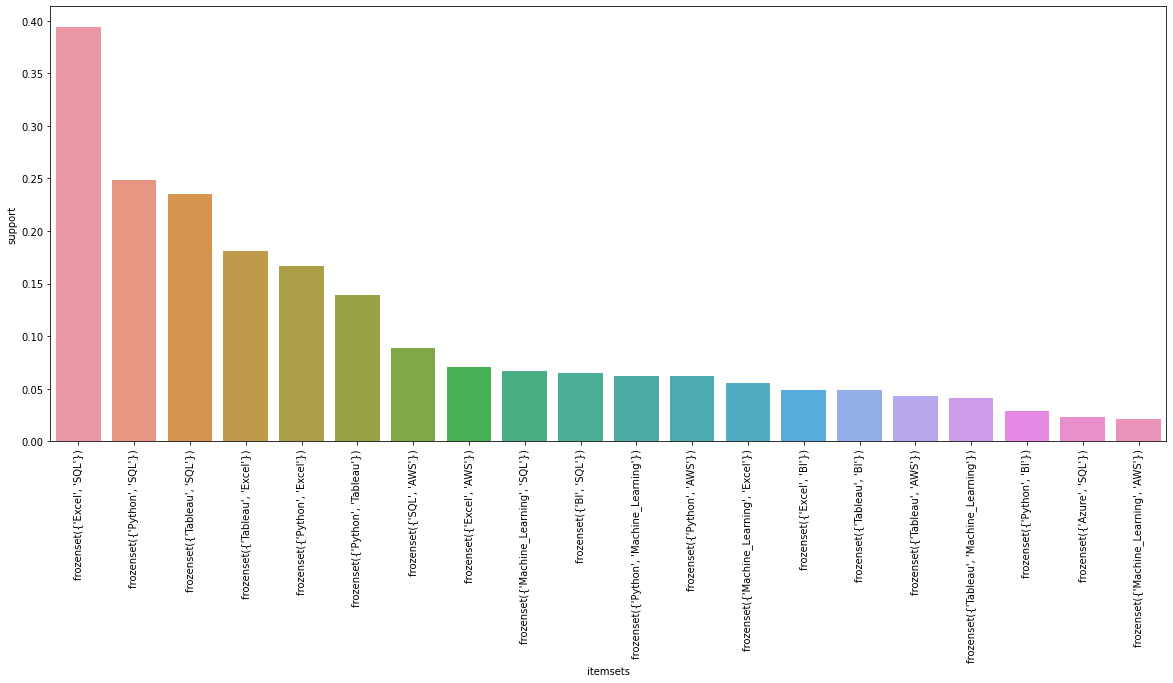

In [13]:
plt.figure(figsize=(20,8))
plt.xticks(rotation = 90)
sns.barplot(x=in_demand2.head(20).itemsets, y = in_demand2.head(20).support)


The most wanted skill duo is **SQL and Excel** from a data analyst position

In [14]:
## the most in-demand skill trios
in_demand3  = df_apriori[df_apriori.length ==3].sort_values('support',ascending=False)
in_demand3.head(5)

,support,itemsets,length
54,0.152685,"(Tableau, Excel, SQL)",3
48,0.151354,"(Python, Excel, SQL)",3
42,0.130493,"(Python, Tableau, SQL)",3
70,0.092321,"(Python, Tableau, Excel)",3
44,0.055925,"(Python, SQL, AWS)",3


<AxesSubplot:xlabel='itemsets', ylabel='support'>

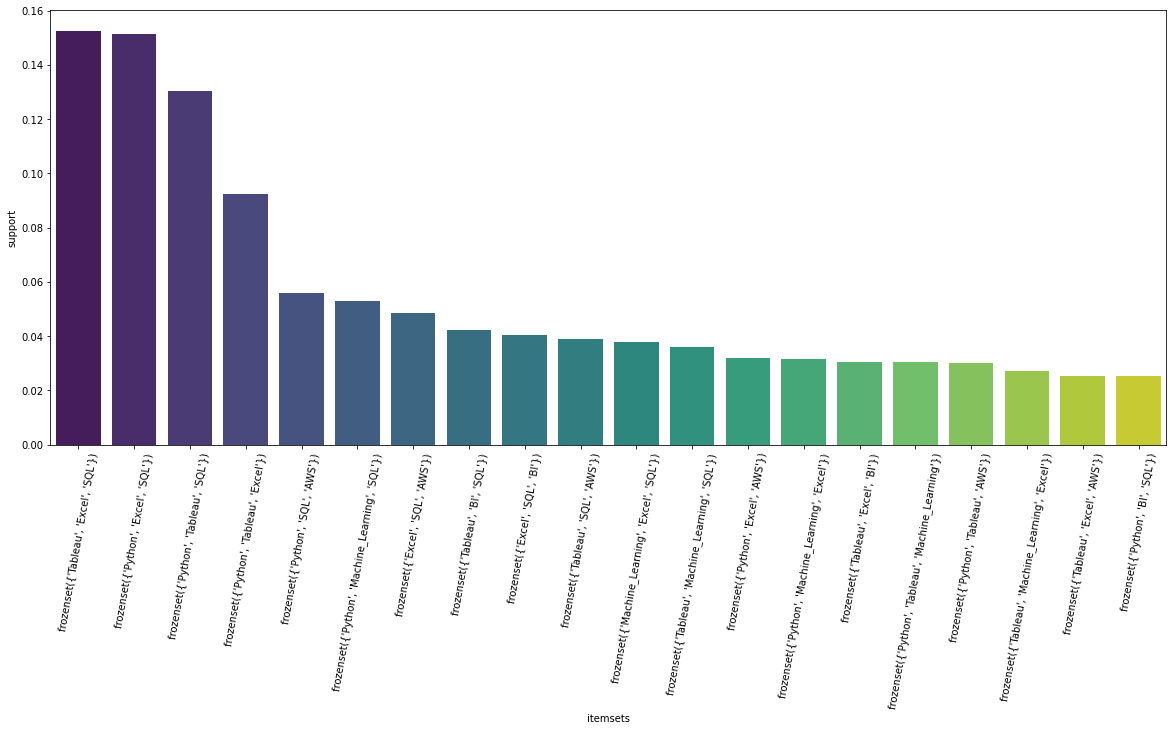

In [15]:
plt.figure(figsize=(20,8))
plt.xticks(rotation = 80)
sns.barplot(x=in_demand3.head(20).itemsets, y = in_demand3.head(20).support,palette='viridis')

Companies require their data analysts to have skills of **SQL, Excel, Tableau** the most. 

In [16]:
skill_price = {}                                                                ## Create a dictionary to be filled
for column in df.iloc[:,10:].columns:                                             ## Loop through each skill column
    skill_price[column]=df[df[column]==1].Avg_Salary_Exp.mean()                   ## fill the dictionary with average price for each skill

{k: v for k, v in sorted(skill_price.items(), key=lambda item: item[1],reverse=True)}    ## sort the skills by value


{'Python': 74733.90894819466,
 'Tableau': 74243.54838709677,
 'Machine_Learning': 73617.37089201878,
 'SQL': 71745.1403887689,
 'Excel': 71614.10635155096,
 'BI': 69844.44444444444,
 'AWS': 69450.90909090909,
 'Azure': 68289.0625,
 'GoogleCloud': 64970.58823529412}

<AxesSubplot:xlabel='skill', ylabel='price'>

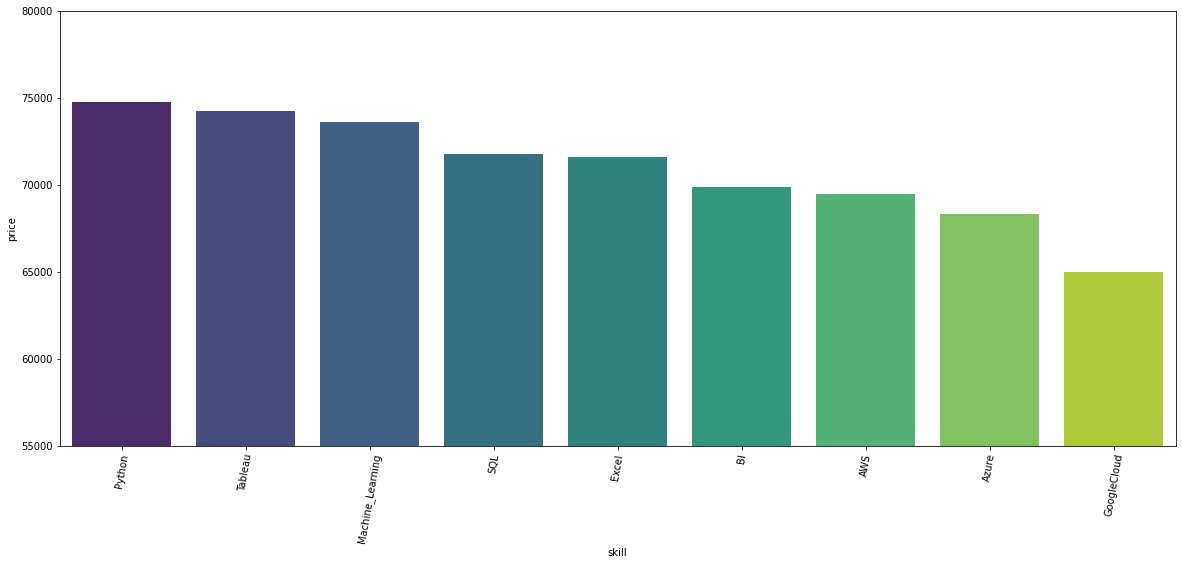

In [17]:
skill_price_df = pd.DataFrame({'skill':skill_price.keys(), 'price':skill_price.values()}).sort_values('price',ascending=False)       ## Create a Dataframe and sort the values
plt.figure(figsize=(20,8))
plt.xticks(rotation = 80)
plt.ylim([55000,80000])
sns.barplot(x= skill_price_df.skill,y=skill_price_df.price,palette='viridis')

As we can see the data shows that the most valuable skills are **Python, Tableau and Machine Learning** for a data analyst/scientist.

In [18]:
df

,Job Title,Job Description,Rating,Company Name,Location,Size,Founded,Sector,Revenue,Avg_Salary_Exp,SQL,Python,Tableau,BI,AWS,GoogleCloud,Azure,Machine_Learning,Excel
0,Data Analyst,Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,New York,201 to 500,1961,Non-Profit,$100 to $500 million (USD),51500.0,1,1,0,0,1,0,0,0,0
1,Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,New York,10000+,1893,Health Care,$2 to $5 billion (USD),51500.0,1,0,0,0,0,0,0,0,1
2,Data Analyst,We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,New York,1001 to 5000,2003,Information Technology,Unknown / Non-Applicable,51500.0,1,1,1,0,0,0,0,0,1
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,New York,201 to 500,2002,Information Technology,$50 to $100 million (USD),51500.0,1,0,1,0,1,0,0,0,0
4,Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,New York,501 to 1000,2009,"Arts, Entertainment & Recreation",$100 to $500 million (USD),51500.0,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248,Rqs - Ihha - -Q Data Security Analyst,Maintains systems to protect data from unautho...,2.5,"Avacend, Inc.",Denver,51 to 200,-1,Business Services,Unknown / Non-Applicable,91000.0,0,0,0,0,0,0,0,0,0
2249,Data Analyst,Position:\nSenior Data Analyst (Corporate Audi...,2.9,Arrow Electronics,Centennial,10000+,1935,Business Services,$10+ billion (USD),91000.0,1,0,1,0,0,0,0,0,0
2250,Business Analyst,"Title: Technical Business Analyst (SQL, Data a...",2.2,Spiceorb,Denver,Unknown,-1,Information Technology,Unknown / Non-Applicable,91000.0,1,0,0,0,0,0,0,0,1
2251,Data Analyst,Summary\n\nResponsible for working cross-funct...,3.1,Contingent Network Services,Centennial,201 to 500,1984,Information Technology,$25 to $50 million (USD),91000.0,1,1,0,0,0,0,0,1,0
